In [1]:
import os
import numpy as np
from scipy.optimize import minimize
from ghgf import hgf
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('talk')

# Example of surprise minimization
## Binary HGF

In [2]:
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

Read binary input from Iglesias et al. (2013).

In [3]:
binary = np.loadtxt(f"{path}/tests/data/binary_input.dat")

Set up standard 3-level HGF for binary inputs.

In [4]:
binstdhgf = hgf.StandardBinaryHGF(
    initial_mu2=0.0,
    initial_pi2=1.0,
    omega2=-2.5,
    kappa2=1.0,
    initial_mu3=1.0,
    initial_pi3=1.0,
    omega3=-8.0,
)

Feed input.

In [5]:
binstdhgf.input(binary)

### Surprize minimization

Set priors.

In [6]:
binstdhgf.x2.omega.trans_prior_mean = -3
binstdhgf.x2.omega.trans_prior_precision = 4 ** -2
binstdhgf.x3.omega.trans_prior_mean = -6
binstdhgf.x3.omega.trans_prior_precision = 4 ** -2

Get the objective function.

In [7]:
binstdf = binstdhgf.neg_log_joint_function()

Minimize the negative log-joint.

In [8]:
binstdx0 = [param.value for param in binstdhgf.var_params]
binstdmin = minimize(binstdf, binstdx0)

## Continous HGF
Up to now, we've only used binary input - 0 or 1. However, many of the most interesting time series are on a continuous scale. As an example, we'll use the exchange rate of the US Dollar to the Swiss Franc during much of 2010 and 2011.
### Model fitting

Read USD-CHF data.

In [9]:
usdchf = np.loadtxt(f"{path}/tests/data/usdchf.dat")

Set up standard 2-level HGF for continuous inputs.

In [87]:
stdhgf = hgf.StandardHGF(
    n_levels=2,
    initial_mu={"1": 1.04, "2": 1.0},
    initial_pi={"1": 1e4, "2": 1e1},
    omega={"1": -13.0, "2": -2.0},
    rho={"1": 0.0, "2": 0.0},
    phi={"1": 0.0, "2": 0.0},
    m={"1": 0.0, "2": 0.0},
    kappa={"1": 1.0}
)

Feed input.

In [88]:
stdhgf.input(usdchf)

### Parameters correlation

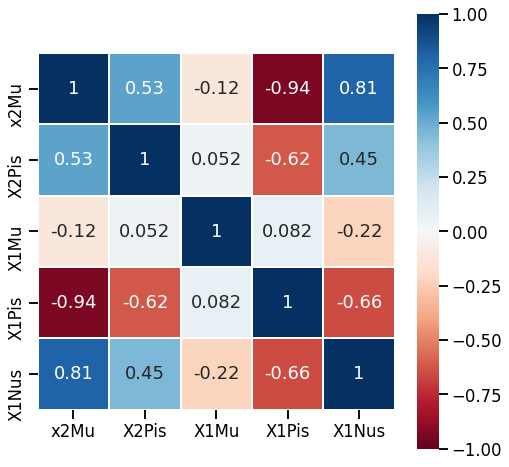

In [76]:
import pandas as pd
df = pd.DataFrame(np.array([
    stdhgf.x2.mus[1:],
    stdhgf.x2.pis[1:],
    stdhgf.x1.mus[1:],
    stdhgf.x1.pis[1:],
    stdhgf.x1.nus[1:],
]).T, columns=['x2Mu', 'X2Pis', 'X1Mu', 'X1Pis', 'X1Nus'])

correlation_mat = df.corr()

plt.figure(figsize=(8, 8))
sns.heatmap(correlation_mat, annot=True, cmap='RdBu', vmin=-1, vmax=1, linewidths=2, square=True)
plt.show()

### Parameters trajectories

In [89]:
def plot_trajectories(model, imput):

    fig, axs = plt.subplots(2, 1, figsize=(21, 8), sharex=True)

    axs[0].fill_between(
        x=np.arange(len(imput)),
        y1=np.array(model.x2.mus[1:]) - np.array(model.x2.pis[1:]), 
        y2=np.array(model.x2.mus[1:]) + np.array(model.x2.pis[1:]),
        alpha=0.2)

    axs[0].plot(model.x2.mus[1:])
    axs[0].set_ylabel('$\mu_{2}$')

    axs[1].plot(model.x1.mus[1:], 'g--', alpha=0.6, label='Posterior expectation of $\mu_{1}$')
    axs[1].set_ylabel('$\mu_{1}$')

    axs[1].plot(imput, color='grey', label='Input data')
    axs[1].set_ylabel('u, $\mu_{1}$')

    plt.legend()
    sns.despine()
    
    return axs

array([<AxesSubplot:ylabel='$\\mu_{2}$'>,
       <AxesSubplot:ylabel='u, $\\mu_{1}$'>], dtype=object)

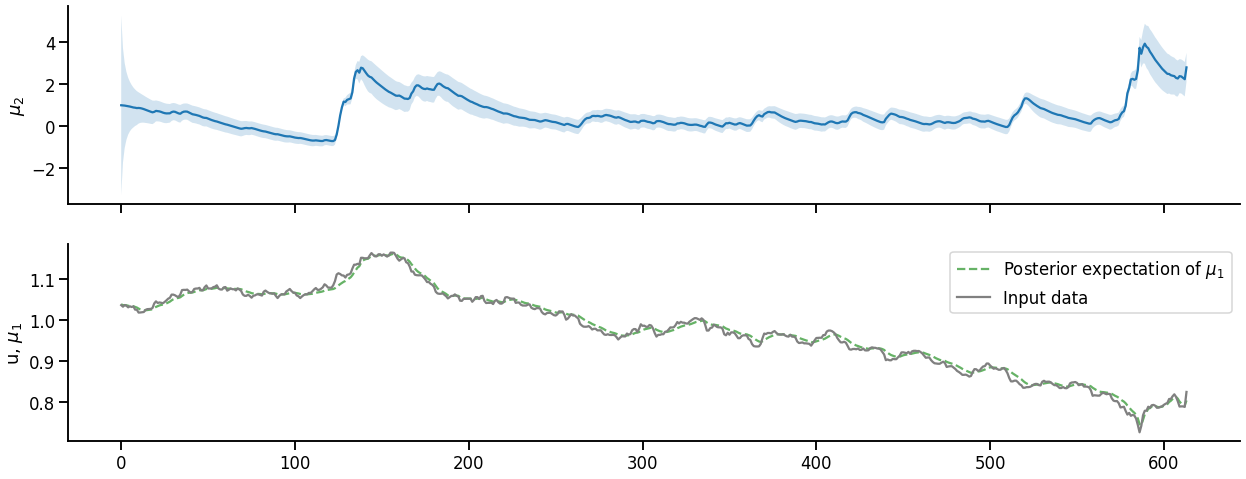

In [90]:
plot_trajectories(stdhgf, usdchf)

Looking at the volatility (ie, the second) level, we see that there are two salient events in our time series where volatility shoots up. The first is in April 2010 when the currency markets react to the news that Greece is effectively broke. This leads to a flight into the US dollar (green dots rising very quickly), sending the volatility higher. The second is an accelarating increase in the value of the Swiss Franc in Augutst and September 2011, as the Euro crisis drags on. The point where the Swiss central bank intervened and put a floor under how far the Euro could fall with respect to the Franc is clearly visible in the Franc's valuation against the dollar. This surprising intervention shows up as another spike in volatitlity.

### Surprize minimization

Set priors.

In [78]:
stdhgf.x1.initial_mu.trans_prior_mean = 1.0375
stdhgf.x1.initial_mu.trans_prior_precision = 4.0625e5

stdhgf.x1.initial_pi.trans_prior_mean = -10.1111
stdhgf.x1.initial_pi.trans_prior_precision = 1

stdhgf.x1.omega.trans_prior_mean = -12.1111
stdhgf.x1.omega.trans_prior_precision = 4 ** -2

stdhgf.x2.initial_pi.trans_prior_mean = -2.3026
stdhgf.x2.initial_pi.trans_prior_precision = 1

stdhgf.x2.omega.trans_prior_mean = -4
stdhgf.x2.omega.trans_prior_precision = 4 ** -2

stdhgf.xU.omega.trans_prior_mean = -10.1111
stdhgf.xU.omega.trans_prior_precision = 2 ** -2

Get the objective function.

In [79]:
stdobjf = stdhgf.neg_log_joint_function()

Minimize the negative log-joint.

In [80]:
stdx0 = [param.value for param in stdhgf.var_params]
stdmin = minimize(stdobjf, stdx0)

C:\ProgramData\Anaconda3\lib\site-packages\ghgf\hgf.py:1220: RuntimeWarning: overflow encountered in exp
  return np.exp(x) + lower_bound


Use the optimied parameters in a new model.

In [83]:
stdmin.x

array([ -2.30260003,  -3.99999993,   1.03749999, -10.11110001,
       -12.11110001, -10.1110995 ])